##Loading packages and Data information

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
%matplotlib inline

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

In [0]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier

In [15]:
data = "https://raw.githubusercontent.com/sungsujaing/DataScience_MachineLearning_Portfolio/master/PrognosticBreaseTumorDetection/dataset_Breast_Cancer_Wisconsis_Prognostic/breast-cancer-wisconsin.data.txt"
cancer_df = pd.read_csv(data, sep=',', skiprows=0, header = None)

attribute_name = ['Sample code number','Clump Thickness','Uniformity of Cell Size','Uniformity of Cell Shape','Marginal Adhesion','Single Epithelial Cell Size','Bare Nuclei','Bland Chromatin','Normal Nucleoli','Mitoses','Class']
cancer_df.columns = attribute_name
cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
Sample code number             699 non-null int64
Clump Thickness                699 non-null int64
Uniformity of Cell Size        699 non-null int64
Uniformity of Cell Shape       699 non-null int64
Marginal Adhesion              699 non-null int64
Single Epithelial Cell Size    699 non-null int64
Bare Nuclei                    699 non-null object
Bland Chromatin                699 non-null int64
Normal Nucleoli                699 non-null int64
Mitoses                        699 non-null int64
Class                          699 non-null int64
dtypes: int64(10), object(1)
memory usage: 60.1+ KB


In [16]:
cancer_df.head()

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


This data set contains 699 samples with 11 attributes (columns). The ***Class*** column will be our key classifier whether the sample is ***Benign*** or ***Malignant*** type tumor.

In [17]:
class_perc = (((cancer_df['Class'].value_counts())/cancer_df['Class'].value_counts().sum()))
print('Dataset is composed of {:.2%} Benign and {:.2%} Malignant tumor information'.format(class_perc[2],class_perc[4]))

Dataset is composed of 65.52% Benign and 34.48% Malignant tumor information


The first column ***'Sample code number'*** would not be consider an attribute for spliting data because they were unique squential numbers to label each sample.

Out of 699 data, 65.52% (class[2]) is considered as ***Benign*** as well as 34.48% (class[4]) is considered as ***Malignant*** cell.




##Data Cleaning

Checking if cancer_df has any NaN('?') values in each column.

In [25]:
cancer_df[cancer_df.isin(['?'])].count()

Sample code number              0
Clump Thickness                 0
Uniformity of Cell Size         0
Uniformity of Cell Shape        0
Marginal Adhesion               0
Single Epithelial Cell Size     0
Bare Nuclei                    16
Bland Chromatin                 0
Normal Nucleoli                 0
Mitoses                         0
Class                           0
dtype: int64

Only ***'Bare Nuclei'*** column has NaN values.
Normally, it will be better to drop all the rows where all the null values are; however, since the data set is very small, all the null values in ***'Bare Nuclei'*** column are replaced with its median value.

In [0]:
cancer_df['Bare Nuclei'] = cancer_df['Bare Nuclei'].map(lambda x: int(x) if x!='?' else np.nan)
cancer_df.fillna({'Bare Nuclei':cancer_df['Bare Nuclei'].median()},inplace=True)
cancer_df['Bare Nuclei'] = cancer_df['Bare Nuclei'].astype('int64')

## EDA

9 attributes (biological parameters) will be used in this project in order to split the data based on the value of the best attribute.

Therefore, we expect to see each attribute has strong correrlation among them. A correlation matrix is used to have a overall view of the correlation among the attributes.

#### Correlation Matrix

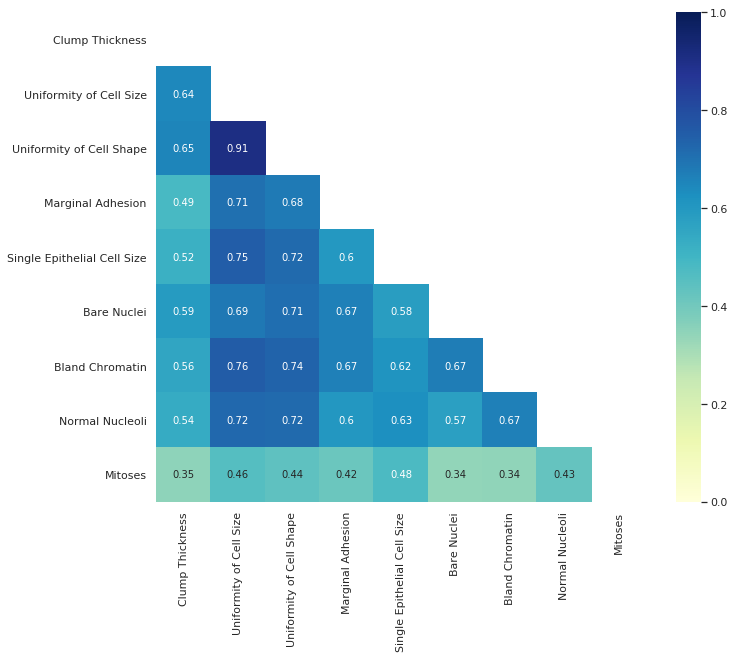

In [28]:
corr_feature = ['Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses']
X = cancer_df[corr_feature]

corr = X.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(11, 9))
ax = sns.heatmap(corr, mask=mask, vmax = 1, vmin = 0, square = True,annot=True,cmap="YlGnBu")
sns.set(font_scale = 1.5)


Based on the matrix, we can determine that most of the attributes are strongly correlated. However, ***'Mitoses (a typical tissue growth that results in ordinary cell division)'*** column has shown relatively weaker correlation among the others. This could be somewhat expected because the tumor cells are known as randomly and abnormaly dviding cells.

### Setting up the Decision Tree

In [30]:
y = cancer_df["Class"]
y[0:5]

0    2
1    2
2    2
3    2
4    2
Name: Class, dtype: int64

In [0]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.2, random_state=3)

### Modeling

In [33]:
cancerTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
cancerTree # it shows the default parameters

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [34]:
cancerTree.fit(X_trainset,y_trainset)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [36]:
predTree = cancerTree.predict(X_testset)
print (predTree[0:5])
print (y_testset[0:5])

[4 4 2 2 2]
386    4
330    4
637    2
647    2
469    2
Name: Class, dtype: int64


### Evaluation

Import **metrics** from sklearn and check accuracy of the model

In [37]:
from sklearn import metrics
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, predTree))

DecisionTrees's Accuracy:  0.9714285714285714


In [0]:
import six

In [0]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.datasets import load_wine
from IPython.display import SVG
from graphviz import Source
from IPython.display import display                               
from ipywidgets import interactive

In [56]:
# class labels
labels = corr_feature

def plot_tree(crit, split, depth, min_split, min_leaf=0.2):

  estimator = DecisionTreeClassifier(random_state = 0 
      , criterion = crit
      , splitter = split
      , max_depth = depth
      , min_samples_split=min_split
      , min_samples_leaf=min_leaf)
    estimator.fit(X, y)

graph = Source(tree.export_graphviz(estimator
      , out_file=None
      , feature_names=labels
      , class_names=['0', '1', '2']
      , filled = True))
   
    display(SVG(graph.pipe(format='svg')))

return estimator
  
inter=interactive(plot_tree 
   , crit = ["gini", "entropy"]
   , split = ["best", "random"]
   , depth=[1,2,3,4]
   , min_split=(0.1,1)
   , min_leaf=(0.1,0.5))


  
display(inter)

IndentationError: ignored